In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad

from binarypredictor.datagen import PolyGenerator, DataGenerator
from binarypredictor.poly import Polynomial, PolynomialSet, PolynomialBatch, PolynomialDataLoader
from binarypredictor.net import DerivativeNet

In [34]:
# Create dataset
dg = DataGenerator()
dg.generate_data(1028)

polys = dg.get_polys()

batch_size = 64
train_loader = PolynomialDataLoader(polys, batch_size, shuffle=True)

100%|█████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:03<00:00, 336.78it/s]


In [38]:
net = DerivativeNet(train=True, in_features=200, hidden_size_linear=256, out_features=10000, hidden_layers=1)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [39]:
x_in = torch.arange(0., 1.0, step=0.01)
x_out = torch.zeros((batch_size, 10000))
x_out[:] = torch.arange(0., 1., step=0.0001)

for i in range(500):
    for p in train_loader:
        inp = p.get_values(x_in, o=0, stack='v')
        out = net(inp.squeeze().float())
                        
        x_range = torch.stack((out, x_out), dim=2)
        dp_vals = p.get_values(x_range, o=1)

        optimizer.zero_grad()
        loss = nn.MSELoss()(dp_vals[:, :, 0], dp_vals[:, :, 1])
        loss.backward(retain_graph=True)
        optimizer.step()
    
    if i % 5 == 0:
        print(loss)

tensor(5.1140, grad_fn=<MseLossBackward0>)
tensor(4.5195, grad_fn=<MseLossBackward0>)
tensor(3.7495, grad_fn=<MseLossBackward0>)
tensor(3.5236, grad_fn=<MseLossBackward0>)
tensor(3.4303, grad_fn=<MseLossBackward0>)
tensor(3.3461, grad_fn=<MseLossBackward0>)
tensor(3.1485, grad_fn=<MseLossBackward0>)
tensor(3.2370, grad_fn=<MseLossBackward0>)
tensor(3.6445, grad_fn=<MseLossBackward0>)
tensor(3.1338, grad_fn=<MseLossBackward0>)
tensor(3.0597, grad_fn=<MseLossBackward0>)
tensor(2.9742, grad_fn=<MseLossBackward0>)
tensor(2.9026, grad_fn=<MseLossBackward0>)
tensor(2.8412, grad_fn=<MseLossBackward0>)
tensor(2.7829, grad_fn=<MseLossBackward0>)
tensor(2.7355, grad_fn=<MseLossBackward0>)
tensor(2.6820, grad_fn=<MseLossBackward0>)
tensor(2.6567, grad_fn=<MseLossBackward0>)
tensor(2.6234, grad_fn=<MseLossBackward0>)
tensor(2.6092, grad_fn=<MseLossBackward0>)
tensor(2.6409, grad_fn=<MseLossBackward0>)
tensor(2.5874, grad_fn=<MseLossBackward0>)
tensor(2.5802, grad_fn=<MseLossBackward0>)
tensor(2.56

In [40]:
pg = PolyGenerator(4)
pg.add_constraint(0.5, 1, 0)
pg.add_constraint(0.1, 0, 1)
pg.add_constraint(0.8, 0, 1)
pg.add_constraint(0.5, 0, 2)
pg.add_constraint(0.9, 0, 5)
#pg.add_constraint(0.2, 0, 2.5)

qg = PolyGenerator(4)
qg.add_constraint(0.5, 1, 0)
qg.add_constraint(0.1, 0, 2)
qg.add_constraint(0.5, 0, -.2)
qg.add_constraint(0.9, 1, -6)
qg.add_constraint(0.9, 0, 8)
#qg.add_constraint(0.2, 0, 1.5)

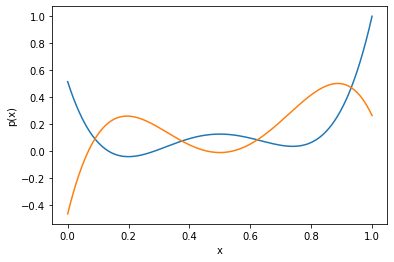

In [48]:
x_in = torch.arange(0., 1.0, step=0.01)

poly_set = PolynomialSet() 
poly_set.append(Polynomial(pg.get_cfs())) 
poly_set.append(Polynomial(qg.get_cfs()))

d_poly_set = poly_set.get_derivatives()

poly_set.scale_by_max(x)
poly_set.plot(x)

In [56]:
inp = poly_set.get_values(x_in, stack='v')

out = (net(inp.squeeze().float()))
x = torch.arange(0., 1., step=0.0001)

x_range = torch.vstack((out, x)).T
dp_vals = d_poly_set.get_values(x_range)

close = (dp_vals[:, 0] - dp_vals[:, 1] < 1e-2) & (dp_vals[:, 0] - dp_vals[:, 1] > -1e-2)

dp_vals_ = dp_vals[close]
out_ = out[close]
x_ = x[close]

valid_idx = torch.where((out_ >= 0) & (out_ <= 1))
out_ = out_[valid_idx]
x_ = x_[valid_idx]

tensor([0.6422, 0.3395], grad_fn=<IndexBackward0>)
tensor([0.2251, 0.8528])


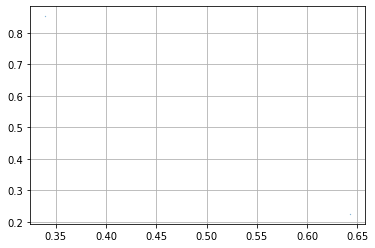

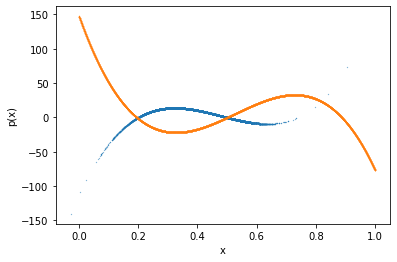

In [54]:
plt.scatter(out_.detach().numpy(), x_, s=.05)
plt.grid()
plt.show()

x_range_ = torch.vstack((out_, x_)).T
d_poly_set.plot(x_range, scatter=True)

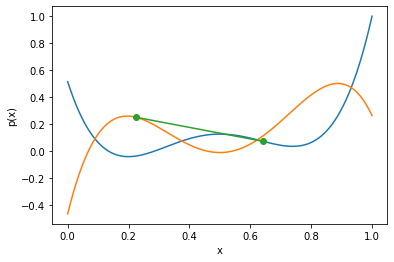

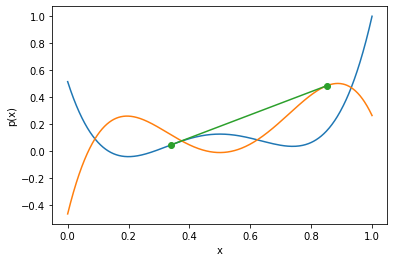

In [62]:
x_range_ = torch.vstack((out_, x_)).T
y = poly_set.get_values(x_range_)

for xp_, xq_, y_ in zip(out_, x_, y):
    poly_set.plot(x)
    plt.plot([xp_.detach().numpy(), xq_.detach().numpy()], [y_[0].detach().numpy(), y_[1].detach().numpy()], marker='o')
    plt.show()